<a href="https://colab.research.google.com/github/FinnRobertson15/PatternAnalysis-2023/blob/topic-recognition/Colab%20version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
%cd

/root


In [19]:
torch.save(trip_model.state_dict(), '/content/drive/MyDrive/model.pth')

RuntimeError: ignored

In [3]:
import zipfile
import os

# Define the paths
zip_path = '/content/drive/MyDrive/AD_NC.zip'  # Path to the zip file
extract_path = '/content/extracted_folder'  # Path where you want to extract the contents

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List the contents of the extracted folder
extracted_files = os.listdir(extract_path)
print(extracted_files)

['AD_NC']


In [4]:
cd /content/extracted_folder/AD_NC

/content/extracted_folder/AD_NC


In [5]:
ls

test/  train/


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import time
import numpy as np
# import pandas as pd
import math
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import shuffle
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder


import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, ConcatDataset
import random
import matplotlib.pyplot as plt

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 96
from torch.utils.data.dataset import Subset, random_split

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_paths[idx])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image

class TripletDataset(Dataset):
    def __init__(self, AD, NC, transform=None):
        self.X = AD + NC
        self.AD = AD
        self.NC = NC
        self.Y = torch.cat((torch.ones(len(AD)), torch.zeros(len(NC))), dim=0)
        self.anc_indices = torch.randperm(len(self.X))
        self.pos_indices = torch.randperm(len(self.X)) % len(AD)
        self.neg_indices = torch.randperm(len(self.X)) % len(NC)
        self.transform = transform

    def __len__(self):
        return len(self.anc_indices)

    def __getitem__(self, idx):
        anc = self.anc_indices[idx]
        pos = self.pos_indices[idx]
        neg = self.neg_indices[idx]
        img1 = self.X[anc]
        img2 = self.AD[pos]
        img3 = self.NC[neg]
        label = self.Y[anc]

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)

        return img1, img2, img3, torch.tensor([1 - label, label])


size = 128

def intensity_normalization(img, mean = None, std = None):
    mean = torch.mean(img)
    std = torch.std(img)
    return (img - mean) / std

class CustomNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        return (img - self.mean) / self.std

transform_train = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),  # Random affine transformations with smaller parameters
    transforms.Lambda(intensity_normalization)
])

transform_test = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Lambda(intensity_normalization)
])

class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        return (img - self.mean) / self.std



# Replace 'your_nii_folder' with the path to your folder containing .nii files
# nii_dataset = NiiDataset(root_dir=r'keras_png_slices_data\keras_png_slices_data\keras_png_slices_train')
loaders = {}
AD_train = CustomDataset(root_dir=os.path.join('train', 'AD'), transform=transform_train)
NC_train = CustomDataset(root_dir=os.path.join('train', 'NC'), transform=transform_train)

X = torch.stack([img for img in AD_train + NC_train])
mean = X.mean()
std = X.std()
normalize = transforms.Compose([
        Normalize(mean, std)
    ])
train_dataset = TripletDataset(AD_train, NC_train, normalize)


# Create data loaders for training and validation data
loaders['train'] = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

AD_test = CustomDataset(root_dir=os.path.join('test', 'AD'), transform=transform_test)
NC_test = CustomDataset(root_dir=os.path.join('test', 'NC'), transform=transform_test)

test_dataset = TripletDataset(AD_test, NC_test, normalize)

split_1 = int(0.5 * len(test_dataset))
split_2 = len(test_dataset) - split_1

# Perform the split
test_dataset, cal_dataset = random_split(test_dataset, [split_1, split_2])

loaders['cal'] = DataLoader(cal_dataset, batch_size=batch_size, shuffle=True)
loaders['test'] = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
len(train_dataset), len(cal_dataset), len(test_dataset)

(21520, 4500, 4500)

In [9]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

class TripletSiameseNetwork(nn.Module):
    def __init__(self, pretrained=True):
        super(TripletSiameseNetwork, self).__init__()
        self.resnet = models.resnet18(pretrained=pretrained)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.fc1 = nn.Linear(1000, 32)
        # self.fc2 = nn.Linear(500, 32)

    def forward_once(self, x):
        output = self.resnet(x)
        output = self.fc1(output)
        # output = self.fc2(output)
        return output

    def forward(self, anchor, positive, negative):
        output_anchor = self.forward_once(anchor)
        output_positive = self.forward_once(positive)
        output_negative = self.forward_once(negative)
        return output_anchor, output_positive, output_negative

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = F.pairwise_distance(anchor, positive)
        distance_negative = F.pairwise_distance(anchor, negative)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

class TripletLossWithRegularization(nn.Module):
    def __init__(self, margin=1.0, lambda_reg=0.0001):
        super(TripletLossWithRegularization, self).__init__()
        self.margin = margin
        self.lambda_reg = lambda_reg  # Regularization parameter

    def forward(self, anchor, positive, negative):
        distance_positive = F.pairwise_distance(anchor, positive)
        distance_negative = F.pairwise_distance(anchor, negative)
        triplet_losses = F.relu(distance_positive - distance_negative + self.margin)
        triplet_loss = triplet_losses.mean()

        # Compute L2 regularization
        l2_reg = None
        for param in trip_model.parameters():
            if l2_reg is None:
                l2_reg = param.norm(2)
            else:
                l2_reg = l2_reg + param.norm(2)

        loss = triplet_loss + self.lambda_reg * l2_reg
        return loss





In [18]:
cd

/root


In [17]:
from torch.optim.lr_scheduler import StepLR
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
learning_rate = 0.05
trip_model = TripletSiameseNetwork()
trip_criterion = TripletLossWithRegularization(margin=1.0)
val_criterion = TripletLoss(margin=1.0)
total_step = len(loaders['train'])

# optimizer = optim.Adam(trip_model.parameters(), lr=learning_rate)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.8)
optimizer = torch.optim.SGD(trip_model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

sched_linear_1 = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.005, max_lr=learning_rate, step_size_up=15, step_size_down=15, mode="triangular", verbose=False)
sched_linear_3 = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.005/learning_rate, end_factor=0.005/learning_rate, verbose=False)
scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[sched_linear_1, sched_linear_3], milestones=[30])

RuntimeError: ignored

Epoch [1 / 10], Step [22 / 225], Loss: 1.5358287719163028, Validation Loss: 1.3388497829437256
Epoch [1 / 10], Step [44 / 225], Loss: 1.4194633120840245, Validation Loss: 1.2655972838401794
Epoch [1 / 10], Step [66 / 225], Loss: 1.2770680965799275, Validation Loss: 1.2275654872258503
Epoch [1 / 10], Step [88 / 225], Loss: 1.1987250704656949, Validation Loss: 1.1871682107448578
Epoch [1 / 10], Step [110 / 225], Loss: 1.1397959481586108, Validation Loss: 1.1396066188812255
Epoch [1 / 10], Step [132 / 225], Loss: 1.10812256146561, Validation Loss: 1.1233381430308025
Epoch [1 / 10], Step [154 / 225], Loss: 1.0751701558565165, Validation Loss: 1.0892583557537623
Epoch [1 / 10], Step [176 / 225], Loss: 1.0456692581488327, Validation Loss: 1.0730071142315865
Epoch [1 / 10], Step [198 / 225], Loss: 1.0179587769688982, Validation Loss: 1.034343745973375
Epoch [1 / 10], Step [220 / 225], Loss: 0.9846788463267413, Validation Loss: 0.9897604703903198


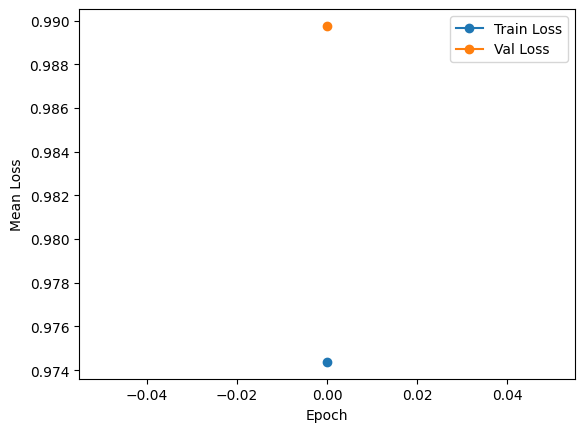

Epoch [2 / 10], Step [22 / 225], Loss: 0.5650029859759591, Validation Loss: 0.6480007767677307
Epoch [2 / 10], Step [44 / 225], Loss: 0.5132254456931894, Validation Loss: 0.5776327848434448
Epoch [2 / 10], Step [66 / 225], Loss: 0.47316857698288833, Validation Loss: 0.5568574070930481
Epoch [2 / 10], Step [88 / 225], Loss: 0.43606940572234715, Validation Loss: 0.5899128615856171
Epoch [2 / 10], Step [110 / 225], Loss: 0.3954015533355149, Validation Loss: 0.5944906234741211
Epoch [2 / 10], Step [132 / 225], Loss: 0.35609302819339617, Validation Loss: 0.537044107913971
Epoch [2 / 10], Step [154 / 225], Loss: 0.33128390105610545, Validation Loss: 0.46129965216719676
Epoch [2 / 10], Step [176 / 225], Loss: 0.2998663415836001, Validation Loss: 0.40397966344607994
Epoch [2 / 10], Step [198 / 225], Loss: 0.2738230372732035, Validation Loss: 0.3590930341742933
Epoch [2 / 10], Step [220 / 225], Loss: 0.25180305100300093, Validation Loss: 0.32318373075686396


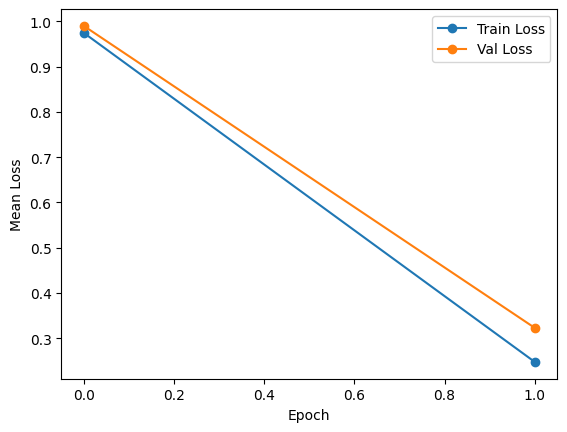

Epoch [3 / 10], Step [22 / 225], Loss: 0.059888842261650345, Validation Loss: 0.055629707872867584
Epoch [3 / 10], Step [44 / 225], Loss: 0.0569748023355549, Validation Loss: 0.04963332414627075
Epoch [3 / 10], Step [66 / 225], Loss: 0.055947076359933075, Validation Loss: 0.033088882764180504
Epoch [3 / 10], Step [88 / 225], Loss: 0.05491821848872033, Validation Loss: 0.024816662073135376
Epoch [3 / 10], Step [110 / 225], Loss: 0.05447610897774046, Validation Loss: 0.0198533296585083
Epoch [3 / 10], Step [132 / 225], Loss: 0.08655590160439412, Validation Loss: 0.019558300574620564
Epoch [3 / 10], Step [154 / 225], Loss: 0.10329984067999698, Validation Loss: 0.0819279168333326
Epoch [3 / 10], Step [176 / 225], Loss: 0.10512340995906429, Validation Loss: 0.07168692722916603
Epoch [3 / 10], Step [198 / 225], Loss: 0.11643278070095212, Validation Loss: 0.07727163698938158
Epoch [3 / 10], Step [220 / 225], Loss: 0.11402303913438862, Validation Loss: 0.08088884353637696


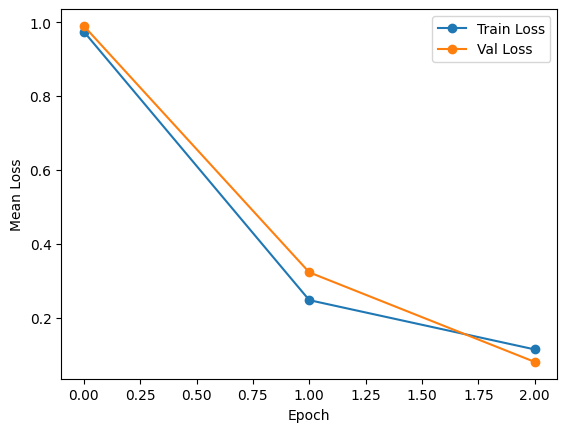

Epoch [4 / 10], Step [22 / 225], Loss: 0.18842411464588207, Validation Loss: 0.023324092850089073
Epoch [4 / 10], Step [44 / 225], Loss: 0.1356671079146591, Validation Loss: 0.011662046425044537
Epoch [4 / 10], Step [66 / 225], Loss: 0.1225995806920709, Validation Loss: 0.007774697616696358
Epoch [4 / 10], Step [88 / 225], Loss: 0.10794795511967757, Validation Loss: 0.013592265080660582
Epoch [4 / 10], Step [110 / 225], Loss: 0.10796696299856359, Validation Loss: 0.011201474699191749
Epoch [4 / 10], Step [132 / 225], Loss: 0.10170525907905716, Validation Loss: 0.009334562249326458
Epoch [4 / 10], Step [154 / 225], Loss: 0.09754940814205579, Validation Loss: 0.020729850894505426
Epoch [4 / 10], Step [176 / 225], Loss: 0.0919922092209824, Validation Loss: 0.019730244923266582
Epoch [4 / 10], Step [198 / 225], Loss: 0.08834527585316788, Validation Loss: 0.09797394703814967
Epoch [4 / 10], Step [220 / 225], Loss: 0.0907003279775381, Validation Loss: 0.0924123348086141


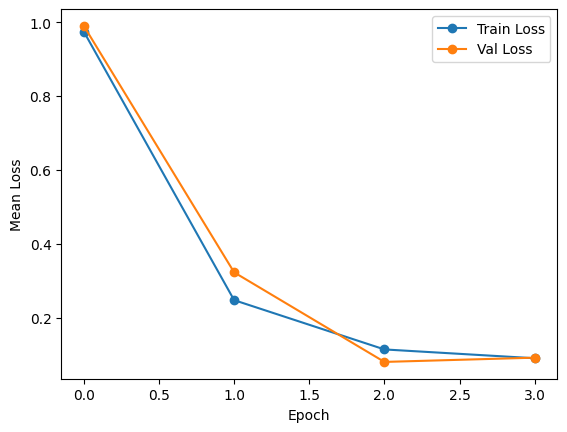

Epoch [5 / 10], Step [22 / 225], Loss: 0.11004065857692198, Validation Loss: 0.20903348922729492
Epoch [5 / 10], Step [44 / 225], Loss: 0.10677469699558886, Validation Loss: 0.12623683735728264
Epoch [5 / 10], Step [66 / 225], Loss: 0.09529317644509402, Validation Loss: 0.08415789157152176
Epoch [5 / 10], Step [88 / 225], Loss: 0.08533265437422828, Validation Loss: 0.06311841867864132
Epoch [5 / 10], Step [110 / 225], Loss: 0.07885887971655889, Validation Loss: 0.05049473494291305
Epoch [5 / 10], Step [132 / 225], Loss: 0.0739773078398271, Validation Loss: 0.04207894578576088
Epoch [5 / 10], Step [154 / 225], Loss: 0.07347074192162457, Validation Loss: 0.07647624505417687
Epoch [5 / 10], Step [176 / 225], Loss: 0.07329438135705212, Validation Loss: 0.09326270315796137
Epoch [5 / 10], Step [198 / 225], Loss: 0.07185688417292002, Validation Loss: 0.08290018058485454
Epoch [5 / 10], Step [220 / 225], Loss: 0.07738829492167994, Validation Loss: 0.0746101625263691


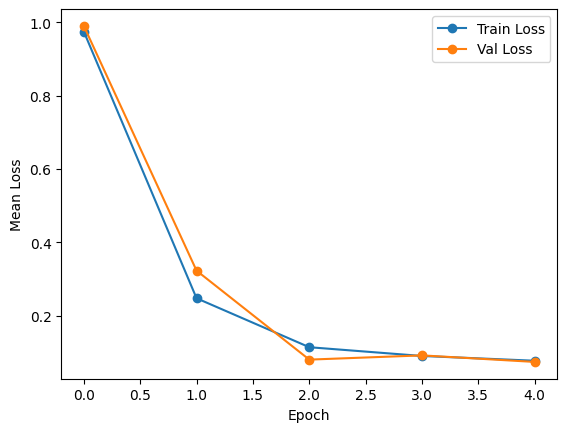

Epoch [6 / 10], Step [22 / 225], Loss: 0.059457464990290726, Validation Loss: 0.01410769484937191
Epoch [6 / 10], Step [44 / 225], Loss: 0.06400176146152345, Validation Loss: 0.01610004436224699
Epoch [6 / 10], Step [66 / 225], Loss: 0.06258460139912186, Validation Loss: 0.01073336290816466
Epoch [6 / 10], Step [88 / 225], Loss: 0.059185962616042656, Validation Loss: 0.008050022181123495
Epoch [6 / 10], Step [110 / 225], Loss: 0.05729963897981427, Validation Loss: 0.006440017744898796
Epoch [6 / 10], Step [132 / 225], Loss: 0.055887209505520084, Validation Loss: 0.00799964057902495
Epoch [6 / 10], Step [154 / 225], Loss: 0.05486652876746345, Validation Loss: 0.006856834782021386
Epoch [6 / 10], Step [176 / 225], Loss: 0.054090704366734084, Validation Loss: 0.005999730434268713
Epoch [6 / 10], Step [198 / 225], Loss: 0.05347813244419868, Validation Loss: 0.005333093719349967
Epoch [6 / 10], Step [220 / 225], Loss: 0.05342629473995079, Validation Loss: 0.004799784347414971


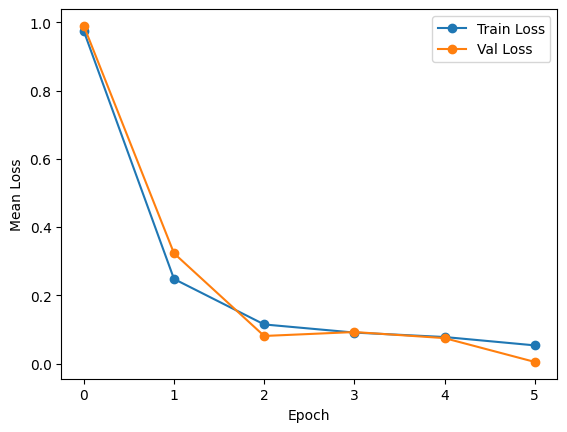

KeyboardInterrupt: ignored

In [11]:
from itertools import cycle

test_iter = cycle(iter(loaders['test']))
# Training loop
epochs = 10
trip_model.to(device)
losses = []
val_losses = []

transform_train = transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05))

for epoch in range(epochs):
  losses.append([])
  val_losses.append([])
  for i, (img1, img2, img3, _) in enumerate(loaders['train']):
    size = img1.size(0)
    img1, img2, img3 = img1[torch.randperm(size)], img2[torch.randperm(size)], img3[torch.randperm(size)]
    img1 = transform_train(img1)
    img2 = transform_train(img2)
    img3 = transform_train(img3)
    img1, img2, img3 = img1.to(device), img2.to(device), img3.to(device)


    out1, out2, out3 = trip_model(img1, img2, img3)

    loss = trip_criterion(out1, out2, out3)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses[epoch].append(loss.item())
    if (i + 1) % (total_step // 10) == 0:

      with torch.no_grad():
        val_img1, val_img2, val_img3, _ = next(test_iter)
        val_img1, val_img2, val_img3 = val_img1.to(device), val_img2.to(device), val_img3.to(device)
        val_out1, val_out2, val_out3 = trip_model(val_img1, val_img2, val_img3)
        val_loss = val_criterion(val_out1, val_out2, val_out3)
        val_losses[epoch].append(val_loss.item())

        print(f"Epoch [{epoch + 1} / {epochs}], Step [{i + 1} / {total_step}], Loss: {np.mean(losses[epoch])}, Validation Loss: {np.mean(val_losses[epoch])}")

  scheduler.step()
  # Calculate mean of each row
  mean_list1 = np.mean(losses, axis=1)
  mean_list2 = np.mean(val_losses, axis=1)

  # Plot the means
  plt.plot(mean_list1, label='Train Loss', marker='o')
  plt.plot(mean_list2, label='Val Loss', marker='o')

  plt.xlabel('Epoch')
  plt.ylabel('Mean Loss')
  plt.legend()
  plt.show()

In [68]:
# # data = {}
# # labels = {}
# trip_model.eval()
# with torch.no_grad():
#   embeddings = trip_model.forward_once
#   for stage in ['train', 'cal', 'test']:
#     data[stage] = []
#     labels[stage] = []
#     for i, (img1, _, _, label) in enumerate(loaders[stage]):
#       img1 = img1.to(device)
#       output = embeddings(img1)
#       data[stage].extend(output.cpu().tolist())
#       labels[stage].extend(label.tolist())

In [12]:
class Classifier(nn.Module):
    def __init__(self, input_size, embedding, hidden_size, output_size):
        super(Classifier, self).__init__()
        self.embedding = embedding
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        with torch.no_grad():
            detached_emb = self.embedding(x).detach()
        print(detached_emb.shape)
        x = torch.relu(detached_emb)  # Taking the mean of embeddings across the embedding dimension
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
# Assuming you have the appropriate input dimensions
input_size = 100  # Assuming 100 input features
embedded_size = 32  # Assuming an embedded size of 50
hidden_size = 100  # Size of the hidden layer
output_size = 2  # Size of the output layer

# Creating an instance of the CustomNet


In [13]:
trip_model.eval()
learning_rate = 0.1
clas_model = Classifier(32, trip_model.forward_once, 100, 2)
clas_criterion = nn.BCELoss()
total_step = len(loaders['train'])

clas_optimizer = optim.Adam(clas_model.parameters(), lr=learning_rate)

In [16]:
from itertools import cycle

test_iter = cycle(iter(loaders['test']))
# Training loop
epochs = 10
clas_model.to(device)
clas_losses = []
clas_val_losses = []

for epoch in range(epochs):
  clas_losses.append([])
  clas_val_losses.append([])
  for i, (img, _, _, label) in enumerate(loaders['train']):
    img, label = img.to(device), label.to(device)


    output = clas_model(img)
    loss = clas_criterion(output, label)
    clas_optimizer.zero_grad()
    loss.backward()
    clas_optimizer.step()
    clas_losses[epoch].append(loss.item())
    if (i + 1) % (total_step // 10) == 0:

      with torch.no_grad():
        val_img, _, _, val_label = next(test_iter)
        val_img, val_label = val_img.to(device), val_label.to(device)
        val_output = clas_model(val_img)
        val_loss = val_criterion(val_output, val_label)
        clas_val_losses[epoch].append(val_loss.item())

        print(f"Epoch [{epoch + 1} / {epochs}], Step [{i + 1} / {total_step}], Loss: {np.mean(clas_losses[epoch])}, Validation Loss: {np.mean(clas_val_losses[epoch])}")

  scheduler.step()
  # Calculate mean of each row
  mean_list1 = np.mean(clas_losses, axis=1)
  mean_list2 = np.mean(clas_val_losses, axis=1)

  # Plot the means
  plt.plot(mean_list1, label='Train Loss', marker='o')
  plt.plot(mean_list2, label='Val Loss', marker='o')

  plt.xlabel('Epoch')
  plt.ylabel('Mean Loss')
  plt.legend()
  plt.show()

RuntimeError: ignored

In [15]:
%env CUDA_LAUNCH_BLOCKING=1


env: CUDA_LAUNCH_BLOCKING=1


In [73]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)

# Train a logistic regression model
# classifier = LogisticRegression(max_iter=1000)
classifier = MLPClassifier(hidden_layer_sizes=(50, 20), max_iter=1000)
classifier.fit(data['cal'], labels['cal'])

# Make predictions
train_predictions = classifier.predict(data['train'])
cal_predictions = classifier.predict(data['cal'])
val_predictions = classifier.predict(data['test'])

# Calculate accuracy
train_accuracy = accuracy_score(labels['train'], train_predictions)
cal_accuracy = accuracy_score(labels['cal'], cal_predictions)
val_accuracy = accuracy_score(labels['test'], val_predictions)
print(f"Train Accuracy: {train_accuracy}")
print(f"Cal Accuracy: {cal_accuracy}")
print(f"Val Accuracy: {val_accuracy}")


Train Accuracy: 0.6839684014869889
Cal Accuracy: 0.8131111111111111
Val Accuracy: 0.7526666666666667
